# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
plt.rcParams.update({
    'font.family':'cmr10',
    'mathtext.fontset': 'cm',
    'axes.formatter.use_mathtext': True,
    'axes.axisbelow': True,
    'figure.figsize': [10.0, 5.0],
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'font.size':15,
    'savefig.directory':'./Images'
})

### Exercise 10.1

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

### Solution 10.1
___
Utilizzando il codice scritto per l'esercizio 9 aggiungiamo la possibilità di far eseguire il codice in parallelo da più processori e che dopo $N_{migr}$ generazioni avvenga una migrazione, cioè i vari processori si scambiano il loro migliore cromosoma (cioè cammino). Per far questo usaimo la libreria di MPI, in particolare, oltre ai comandi di inizializzazione e finalizzazione di MPI, usiamo `MPI_Gather`, `MPI_BCast` e `MPI_Reduce`.
Nel nostro caso specifico:
- Con `MPI_Gather`, raccogliamo da ciascun processo il percorso migliore nel processo con rank 0, e li organizziamo in una matrice, dove ogni colonna rappresenta il percorso ottimale individuato da un determinato processo. Una volta costruita la matrice, le colonne vengono mescolate casualmente (shuffle), ottenendo così una nuova disposizione dei percorsi.
- Con `MPI_Bcast`, la matrice rimescolata viene trasmessa a tutti i processi. A questo punto, ciascun processo seleziona come nuovo percorso quello contenuto nella colonna corrispondente al proprio rank. In questo modo, ogni processo utilizzerà il percorso migliore di un altro processo, grazie al rimescolamento effettuato in precedenza.
- Alla fine di tutte le generazioni utilizziamo `MPI_Reduce` per selezionare il percorso migliore tra quelli ottenuti da ciascun processo. In particolare, inviamo la loss associata al percorso finale di ogni processo, trattandola come una funzione di cui vogliamo trovare il minimo. Grazie all’operatore `MPI_MINLOC`, siamo in grado di individuare sia il valore minimo della loss, sia il rank del processo che l’ha generata. Una volta identificato il processo con il miglior risultato, salviamo come configurazione finale il percorso ottimale calcolato da quel processo. 

I percorsi vengono trasferiti tra i processi come vettori di Armadillo, contenenti esclusivamente gli ID delle città nell’ordine in cui compaiono nel percorso. Questo approccio è necessario perché MPI non è in grado di inviare o ricevere oggetti complessi, come i field delle classi.
Di conseguenza, una volta ricevuto il "nuovo" percorso, ogni processo deve ricostruire il cromosoma corrispondente, ovvero recuperare tutte le informazioni necessarie sulla posizione di ciascuna città.
Per fare ciò, ho implementato una funzione che, dato un certo ordine di ID delle città, è in grado di ricostruire il cromosoma completo, ripristinando tutte le coordinate e le informazioni associate a ciascuna città.

Inoltre per far sì che ogni processo non sia uguale agli altri bisogna far si che il generatore di numeri casuali abbia un seme diverso per ogni rank, quindi nella funzione che inizializza la configuazione, dopo aver generato il cromosoma iniziale, che deve essere uguale per ogni processo, con le città disposte in base alle varie configurazione possibili (cerchio, quadrato, dati da file), modifichiamo il seed in modo che ogni estrazione causuale successiva sia diversa per ogni processo. Per far questo ho creato un metodo nella classe `Random` che modifichi il Seed (`SetSeed(int )`) e ho impostato che il seed di ogni processo sia uguale a `rank+1`.

Testiamo questo codice sulle due configuazioni che abbiamo usato anche nell'esercizio 9, tenendo tutti i parametri uguali a quelli dell'esercizio precedente e impostando $N_{migr} = 50$ (cioè la migrazione avviene ogni 50 generazioni), usando 6 processi in parallelo. E otteniamo i seguenti risultati:



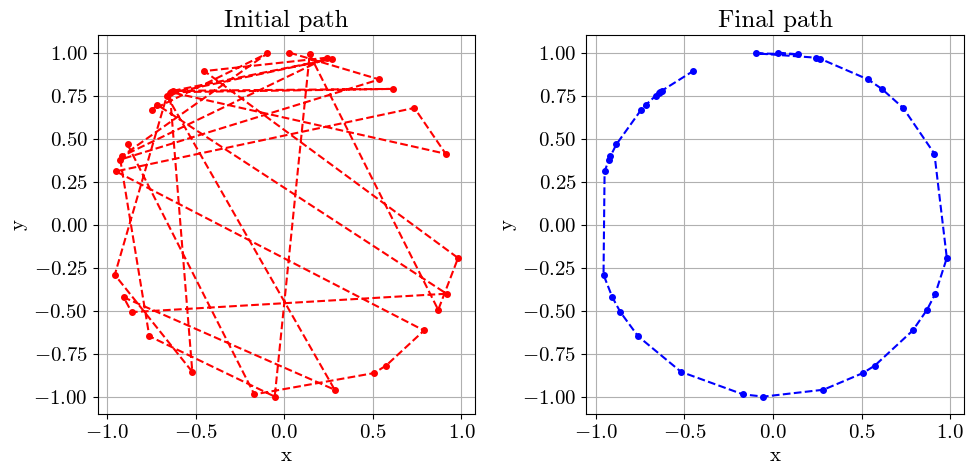

In [67]:
#CERCHIO
best = np.loadtxt("OUTPUT/CIRCLE/best_config_iniziale.dat")
x1 = best[:,1]
y1 = best[:,2]

medio = np.loadtxt("OUTPUT/CIRCLE/best_config.dat")
x = medio[:,1]
y = medio[:,2]

plt.figure(1)
plt.subplot(1,2,1)
plt.plot(x1,y1,'o',color='red', linestyle = '--', markersize = 4)
plt.title('Initial path')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(x,y,'o',color='blue', linestyle = '--', markersize = 4)
plt.title('Final path')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()

plt.show()

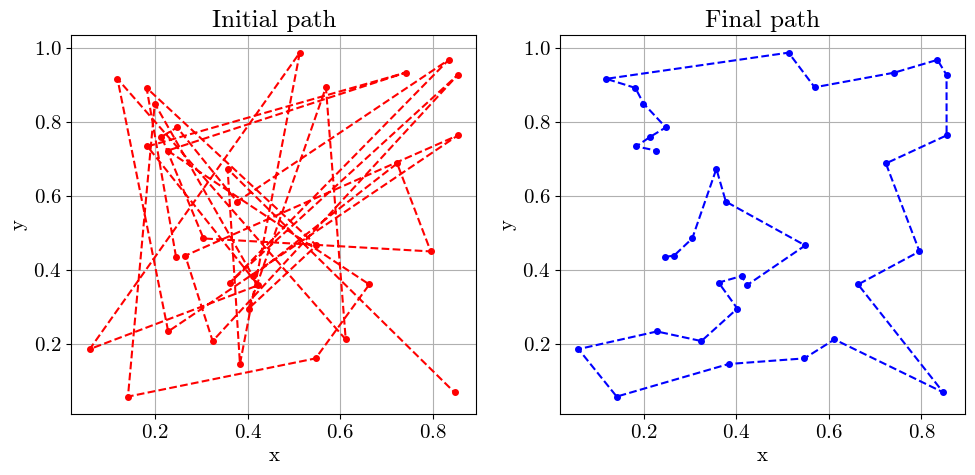

In [68]:
#quadrato
best = np.loadtxt("OUTPUT/SQUARE/best_config_iniziale.dat")
x1 = best[:,1]
y1 = best[:,2]

medio = np.loadtxt("OUTPUT/SQUARE/best_config.dat")
x = medio[:,1]
y = medio[:,2]

plt.figure(1)
plt.subplot(1,2,1)
plt.plot(x1,y1,'o',color='red', linestyle = '--', markersize = 4)
plt.title('Initial path')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(x,y,'o',color='blue', linestyle = '--', markersize = 4)
plt.title('Final path')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()

plt.show()

### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

### Solzione 10.2
___

Eseguendo il codice con gli stessi parametri vediamo che la parallelizzazione dell'algoritmo permette di raggiungere un risultato migliore. Notiamo inoltre miglioramenti nella funzione costo in corrispondenza del passo in cui avviene la migrazione (linea tratteggiata gialla in figura).

Per raggiungere il risultato desiderto nella minimizzazione del percorso tra le città d'Italia ho dovuto aumentare il numero di generazioni, quindi rispetto alle altre simulazioni ho modificato i seguenti parametri:
- $N_{generation} = 1000$
- $N_{chrom} = 300$
- $N_{migr} = 40$

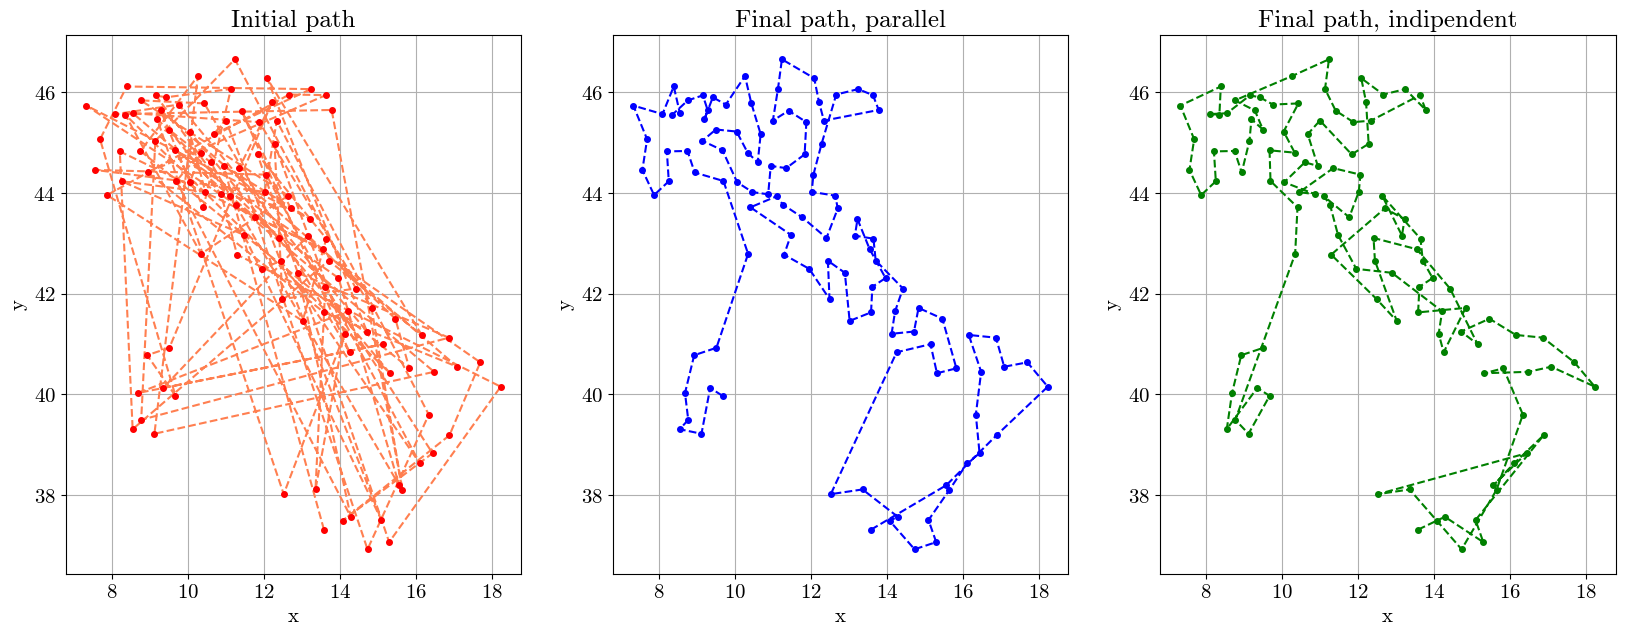

In [110]:
#prove
best_iniz = np.loadtxt("OUTPUT/FILE/best_config_iniziale.dat")
x_iniz = best_iniz[:,1]
y_iniz = best_iniz[:,2]

best = np.loadtxt("OUTPUT/FILE/best_config.dat")
x = best[:,1]
y = best[:,2]

best_indip = np.loadtxt("../ES9/OUTPUT/FILE/best_config.dat")
x_indip = best_indip[:,1]
y_indip = best_indip[:,2]

plt.figure(1,figsize=(20,7))
plt.subplot(1,3,1)
plt.plot(x_iniz,y_iniz,'o',color='coral', linestyle = '--', markersize = 4, markerfacecolor = 'red', markeredgecolor = 'red')
plt.title('Initial path')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(x,y,'o',color='blue', linestyle = '--', markersize = 4, label = 'parallel')
plt.title('Final path, parallel')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.subplot(1,3,3)
plt.plot(x_indip,y_indip,'o',color='green', linestyle = '--', markersize = 4, label = 'indipendent')
plt.title('Final path, indipendent')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.show()

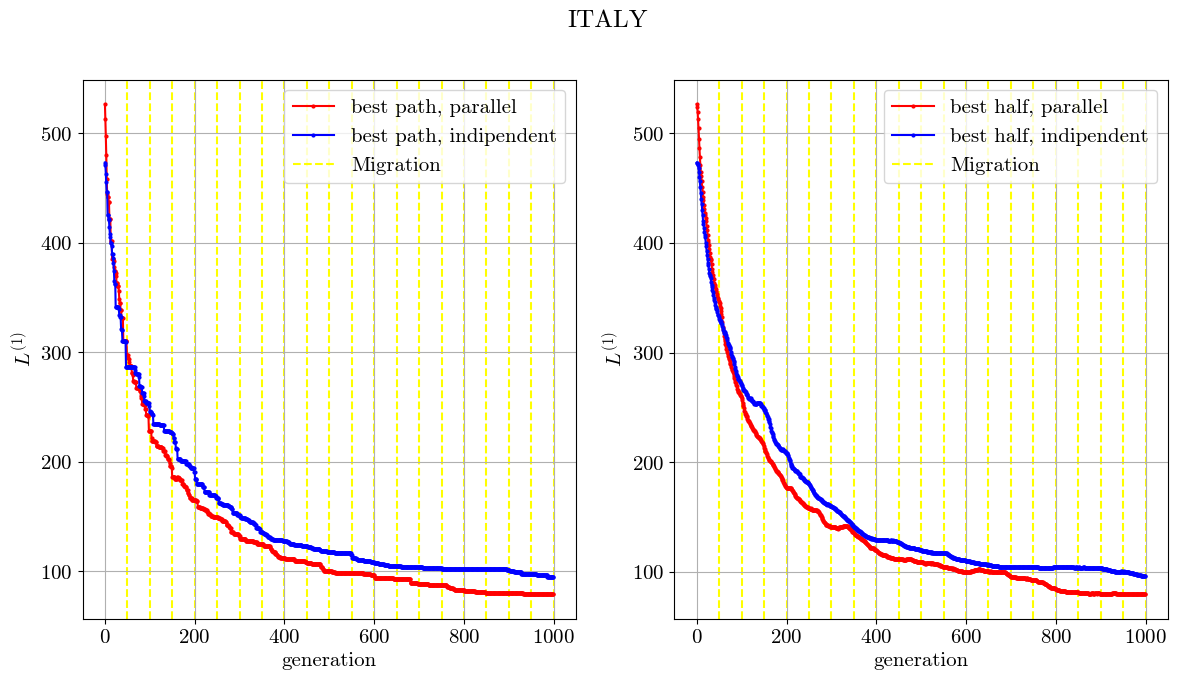

In [107]:
#ITALY
best1 = np.loadtxt("OUTPUT/FILE/L1_best.dat")
x1 = best1[:,0]
y1 = best1[:,1]

best_indip = np.loadtxt("../ES9/OUTPUT/FILE/L1_best.dat")
x_b_indip = best_indip[:,0]
y_b_indip = best_indip[:,1]

medio1 = np.loadtxt("OUTPUT/FILE/L1_medio.dat")
x = medio1[:,0]
y = medio1[:,1]

medio_indip = np.loadtxt("../ES9/OUTPUT/FILE/L1_medio.dat")
x_indip = medio_indip[:,0]
y_indip = medio_indip[:,1]
migration = 50

fig1 = plt.figure(1,figsize=(14,7))
fig1.suptitle('ITALY')
plt.subplot(1,2,1)
plt.plot(x1,y1,'o',color='red', linestyle = '-', markersize = 2, label = 'best path, parallel')
plt.plot(x_b_indip,y_b_indip,'o',color='blue', linestyle = '-', markersize = 2, label = 'best path, indipendent')
for i in range(0,int(len(x)/migration)):
    mig = plt.axvline(x=migration*(i+1),linestyle='--',color='yellow',zorder=-1)
mig.set_label("Migration")
plt.xlabel('generation')
plt.ylabel('$ L^{(1)}$')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,y,'o',color='red', linestyle = '-', markersize = 2, label = 'best half, parallel')
plt.plot(x_indip,y_indip,'o',color='blue', linestyle = '-', markersize = 2, label = 'best half, indipendent')
for i in range(0,int(len(x)/migration)):
    mig = plt.axvline(x=migration*(i+1),linestyle='--', color='yellow',zorder=-1)
mig.set_label("Migration")
plt.xlabel('generation')
plt.ylabel('$L^{(1)}$')
plt.grid(True)
plt.legend()


Confrontando le loss anche nel caso delle altre configuazioni quello che si ottiene è che non si notano molte differenze se non l'osservazione che facevamo prima sul migliormento aggiuntivo che si nota in corrispondenza dei passi in cui avviene la migrazione.

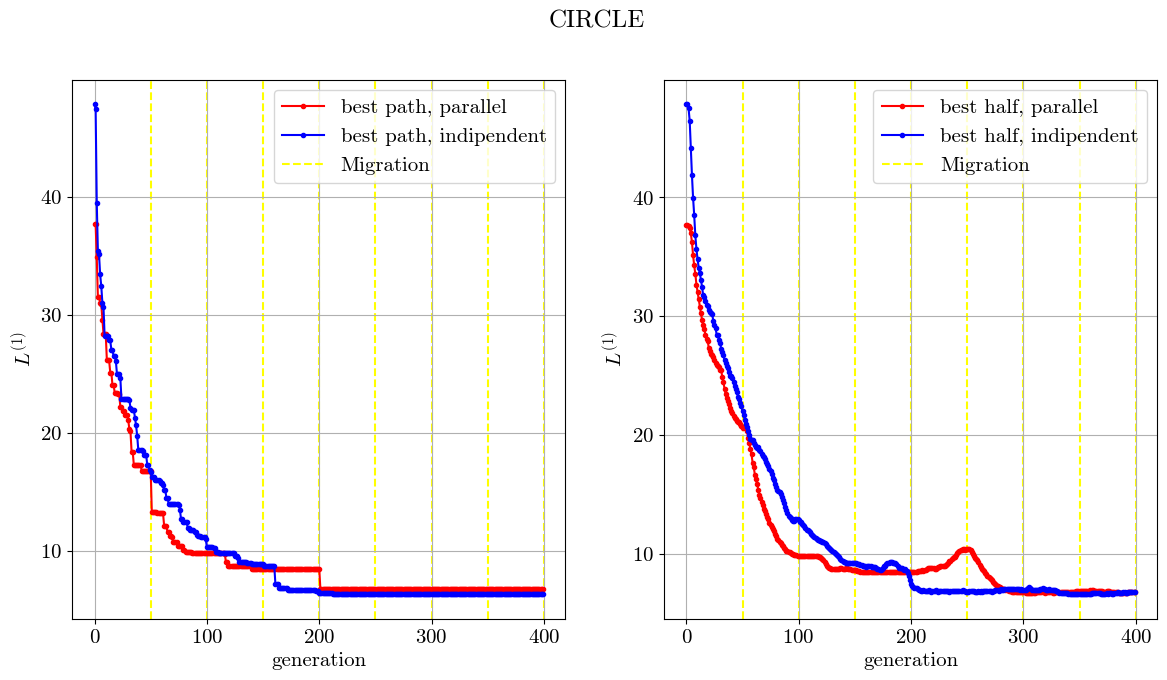

In [108]:
#CIRCLE
best1 = np.loadtxt("OUTPUT/CIRCLE/L1_best.dat")
x1 = best1[:,0]
y1 = best1[:,1]

best_indip = np.loadtxt("../ES9/OUTPUT/CIRCLE/L1_best.dat")
x_b_indip = best_indip[:,0]
y_b_indip = best_indip[:,1]

medio1 = np.loadtxt("OUTPUT/CIRCLE/L1_medio.dat")
x = medio1[:,0]
y = medio1[:,1]

medio_indip = np.loadtxt("../ES9/OUTPUT/CIRCLE/L1_medio.dat")
x_indip = medio_indip[:,0]
y_indip = medio_indip[:,1]

migration = 50

fig1 = plt.figure(1,figsize=(14,7))
fig1.suptitle('CIRCLE')
plt.subplot(1,2,1)
plt.plot(x1,y1,'o',color='red', linestyle = '-', markersize = 3, label = 'best path, parallel')
plt.plot(x_b_indip,y_b_indip,'o',color='blue', linestyle = '-', markersize = 3, label = 'best path, indipendent')
for i in range(0,int(len(x)/migration)):
    mig = plt.axvline(x=migration*(i+1),linestyle='--', color='yellow',zorder=-1)
mig.set_label("Migration")
plt.xlabel('generation')
plt.ylabel('$ L^{(1)}$')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,y,'o',color='red', linestyle = '-', markersize = 3, label = 'best half, parallel')
plt.plot(x_indip,y_indip,'o',color='blue', linestyle = '-', markersize = 3, label = 'best half, indipendent')
for i in range(0,int(len(x)/migration)):
    mig = plt.axvline(x=migration*(i+1),linestyle='--', color='yellow',zorder=-1)
mig.set_label("Migration")
plt.xlabel('generation')
plt.ylabel('$L^{(1)}$')
plt.grid(True)
plt.legend()


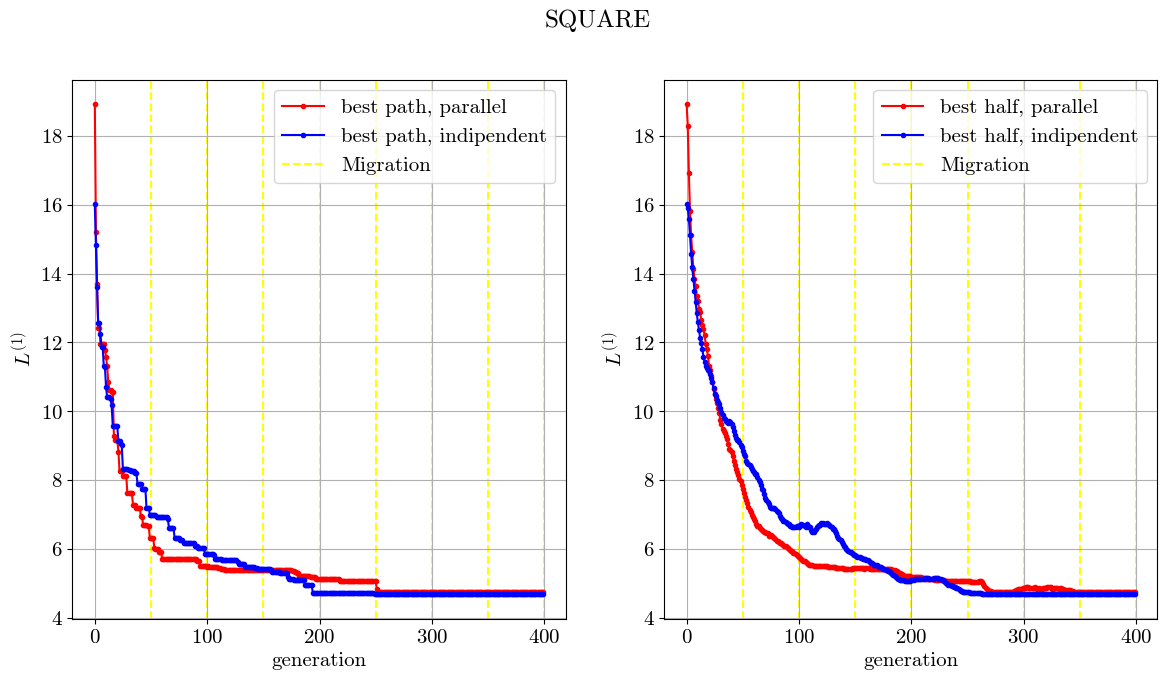

In [109]:
#CIRCLE
best1 = np.loadtxt("OUTPUT/SQUARE/L1_best.dat")
x1 = best1[:,0]
y1 = best1[:,1]

best_indip = np.loadtxt("../ES9/OUTPUT/SQUARE/L1_best.dat")
x_b_indip = best_indip[:,0]
y_b_indip = best_indip[:,1]

medio1 = np.loadtxt("OUTPUT/SQUARE/L1_medio.dat")
x = medio1[:,0]
y = medio1[:,1]

medio_indip = np.loadtxt("../ES9/OUTPUT/SQUARE/L1_medio.dat")
x_indip = medio_indip[:,0]
y_indip = medio_indip[:,1]

migration = 50

fig1 = plt.figure(1,figsize=(14,7))
fig1.suptitle('SQUARE')
plt.subplot(1,2,1)
plt.plot(x1,y1,'o',color='red', linestyle = '-', markersize = 3, label = 'best path, parallel')
plt.plot(x_b_indip,y_b_indip,'o',color='blue', linestyle = '-', markersize = 3, label = 'best path, indipendent')
for i in range(0,int(len(x)/migration)):
    mig = plt.axvline(x=migration*(i+1),linestyle='--', color='yellow',zorder=-1)
mig.set_label("Migration")
plt.xlabel('generation')
plt.ylabel('$ L^{(1)}$')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,y,'o',color='red', linestyle = '-', markersize = 3, label = 'best half, parallel')
plt.plot(x_indip,y_indip,'o',color='blue', linestyle = '-', markersize = 3, label = 'best half, indipendent')
for i in range(0,int(len(x)/migration)):
    mig = plt.axvline(x=migration*(i+1),linestyle='--', color='yellow',zorder=-1)
mig.set_label("Migration")
plt.xlabel('generation')
plt.ylabel('$L^{(1)}$')
plt.grid(True)
plt.legend()
